In [ ]:

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
#1. Load Datasets

# Define the base path and dataset paths
base_path = Path("/Users/lina/code/yukaberry/detect_ai_content/raw_data/new_datasets")

df_ai_human = pd.read_csv(base_path / "AI_Human.csv")
df_augdata_llm_detectai_train = pd.read_csv(base_path / "AugData_LLM_DetectAI/final_train.csv")
df_huggingface = pd.read_csv(base_path / "model_training_dataset.csv")
df_human_vs_llm = pd.read_csv(base_path / "Human_vs_LLM_Corpus/data.csv")
df_train_v2_drcat = pd.read_csv(base_path / "train_v2_drcat_02.csv")

# Create a dictionary to hold references to these datasets
datasets = {
    "df_ai_human": df_ai_human,
    "df_augdata_llm_detectai_train": df_augdata_llm_detectai_train,
    "df_huggingface": df_huggingface,
    "df_human_vs_llm": df_human_vs_llm,
    "df_train_v2_drcat": df_train_v2_drcat
}

In [ ]:
for df_name, df in datasets.items():
    print(f"\nDataset name: {df_name}")
    print("Columns:", df.columns.values)
    print(df.head(1))
    print("----------------------------------")

### ENCODING

In [ ]:
def process_huggingface_dataset(df):
    """
    Processes the Hugging Face dataset by separating human and AI text with labels.
    
    Parameters:
        df (pd.DataFrame): The original Hugging Face DataFrame with 'human_text' and 'ai_text' columns.
    
    Returns:
        pd.DataFrame: A DataFrame with 'text' and 'generated' columns, where 'generated' is 0 for human text and 1 for AI text.
    """
    # Process human and AI text into separate DataFrames with labels
    human_text_df = df[['id', 'human_text']].rename(columns={'human_text': 'text'})
    human_text_df['generated'] = 0  # Label for human-generated text

    ai_text_df = df[['id', 'ai_text']].rename(columns={'ai_text': 'text'})
    ai_text_df['generated'] = 1  # Label for AI-generated text

    # Concatenate both DataFrames
    combined_text_df = pd.concat([human_text_df, ai_text_df], ignore_index=True)
    
    # Display class distribution for verification
    print("\nClass Distribution:")
    print(combined_text_df['generated'].value_counts())
    
    return combined_text_df

# Example usage
# Assuming df_huggingface is already loaded
df_processed_huggingface = process_huggingface_dataset(df_huggingface)


In [ ]:

def encode_human_vs_llm_corpus(df):
    # Map 'source' column to binary 'label': Human as 0, GPT-3.5 and Other as 1
    df['label'] = df['source'].apply(lambda x: 0 if x == 'Human' else 1)
    
    # Select relevant columns for the analysis
    df = df[['text', 'label', 'text_length', 'word_count']]
    
    # Display the first few rows to confirm
    print("\nClass Distribution:")
    print(df['label'].value_counts(normalize=True) * 100)
    
    return df
# Apply encoding
df_encoded_human_vs_llm = encode_human_vs_llm_corpus(df_human_vs_llm)

In [ ]:
# Shuffling Datasets Once

# Shuffle datasets to ensure random distribution
df_ai_human = df_ai_human.sample(frac=1, random_state=42).reset_index(drop=True)
df_augdata_llm_detectai_train = df_augdata_llm_detectai_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_huggingface = df_processed_huggingface.sample(frac=1, random_state=42).reset_index(drop=True)
df_encoded_human_vs_llm = df_human_vs_llm.sample(frac=1, random_state=42).reset_index(drop=True)
df_train_v2_drcat = df_train_v2_drcat.sample(frac=1, random_state=42).reset_index(drop=True)



Class Distribution in AI Human Dataset:
   generated  Percentage
0        0.0   62.761706
1        1.0   37.238294


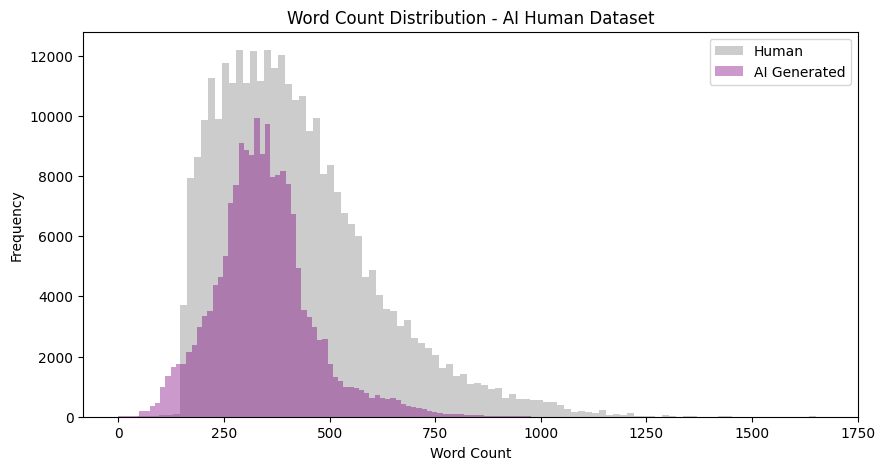

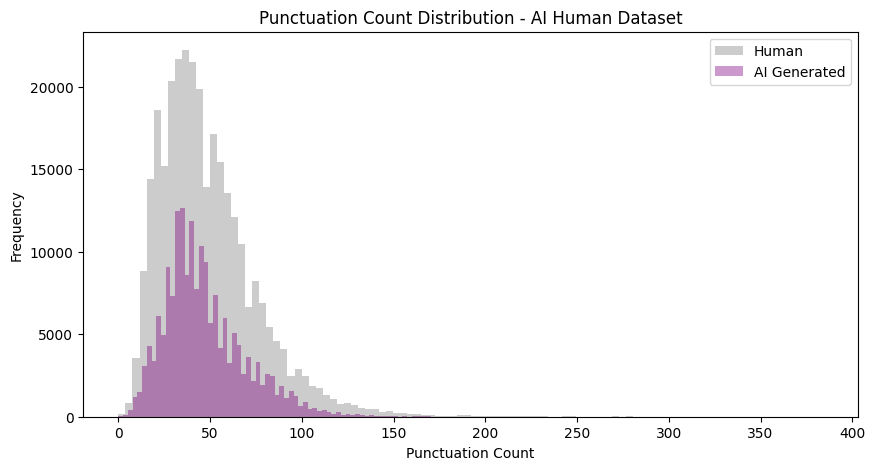


Class Distribution in AugData LLM DetectAI Train Dataset:
   label  Percentage
0      0   64.025569
1      1   35.974431


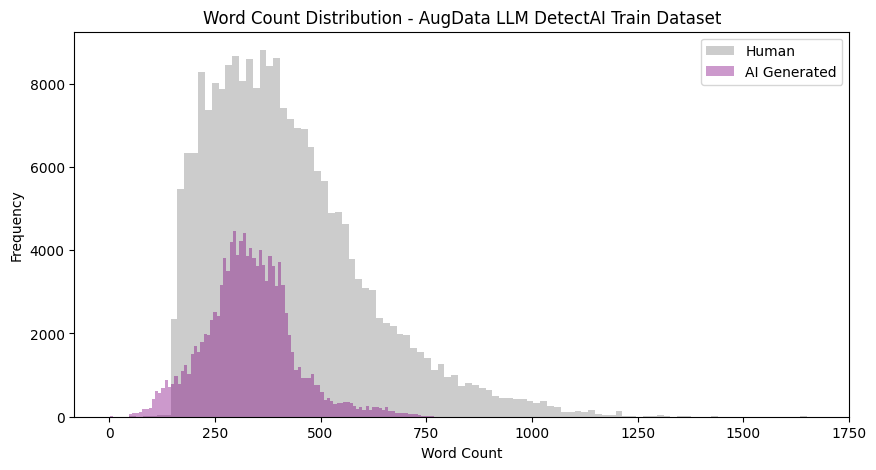

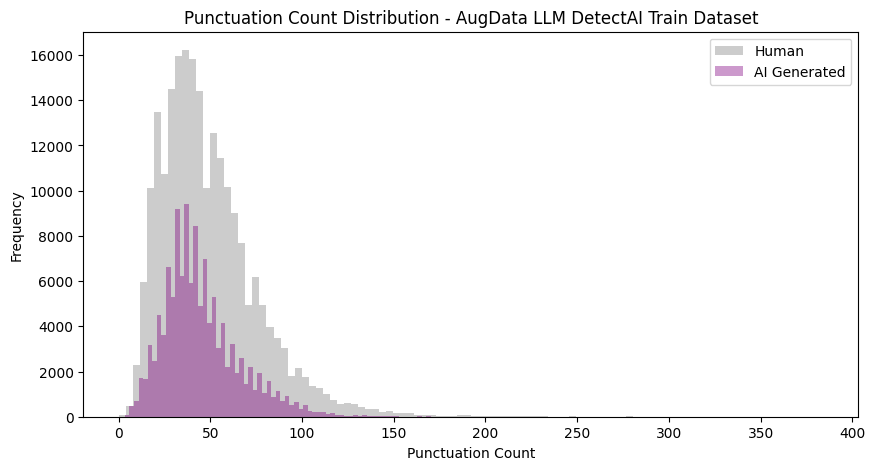


Class Distribution in Huggingface Dataset:
   generated  Percentage
0          1        50.0
1          0        50.0


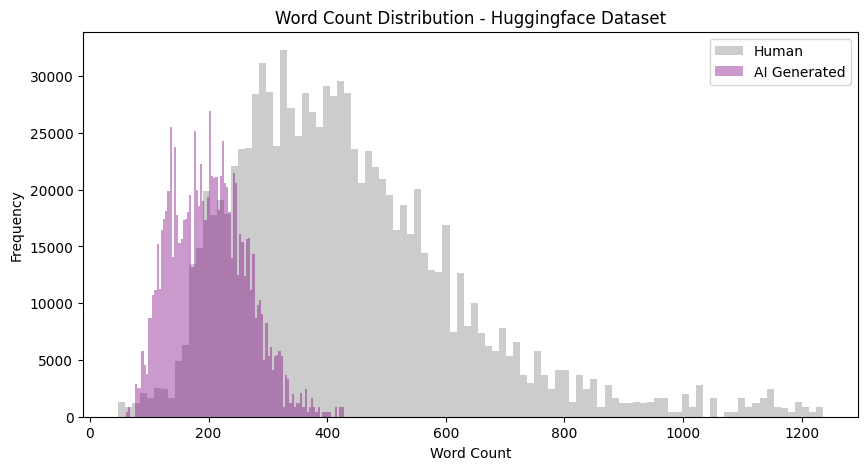

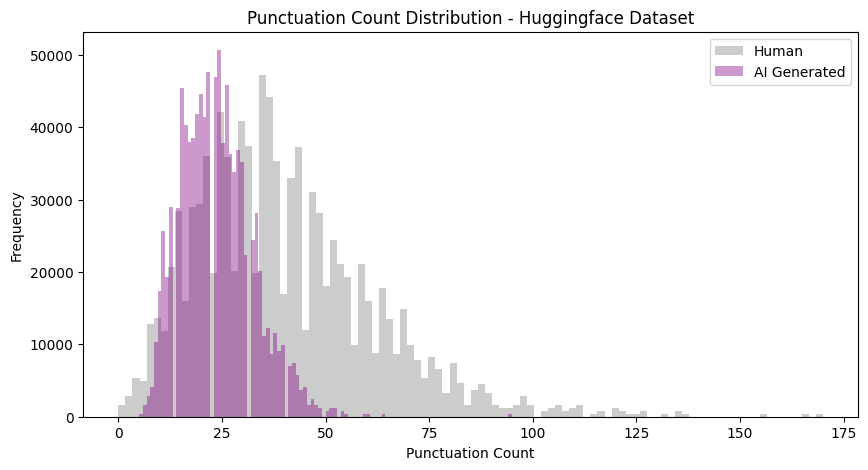


Class Distribution in Human vs LLM Corpus:
   label  Percentage
0      1   55.928216
1      0   44.071784


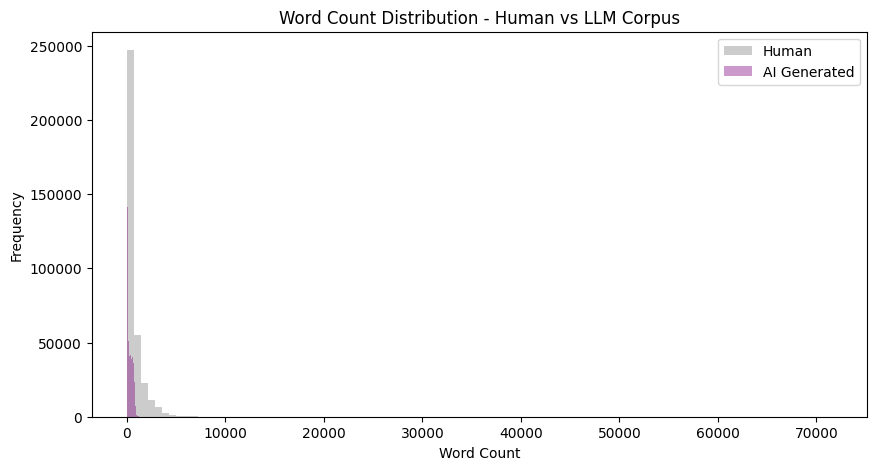

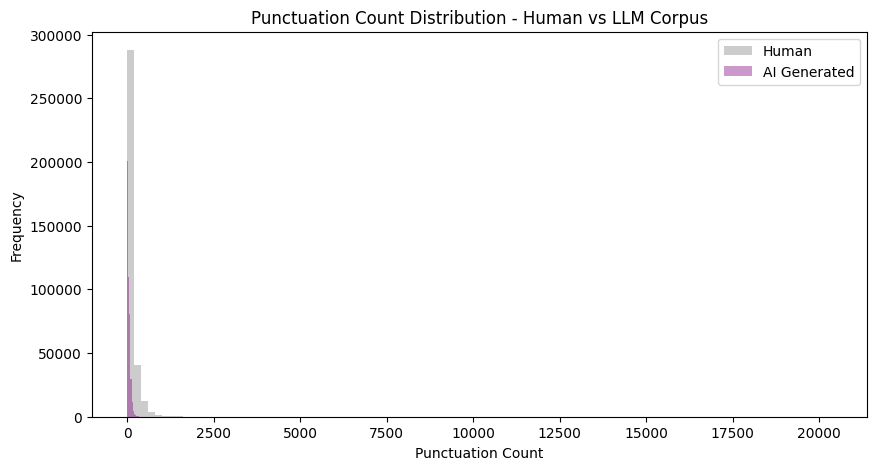


Class Distribution in Train V2 DRcat Dataset:
   label  Percentage
0      0   61.003388
1      1   38.996612


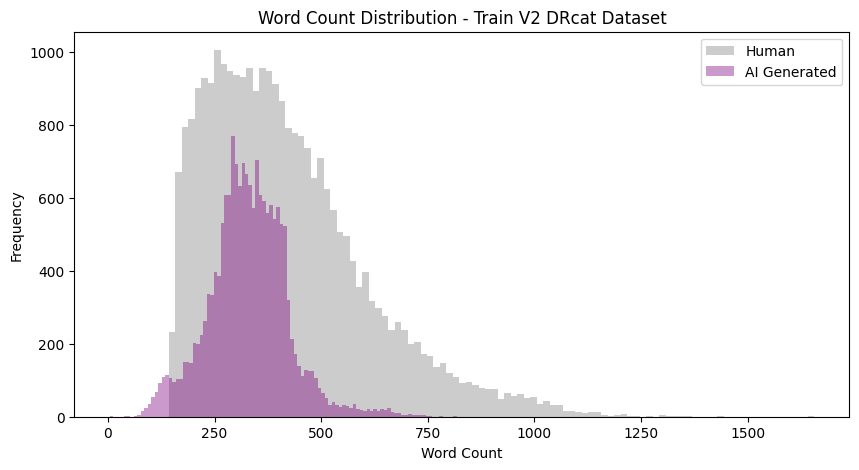

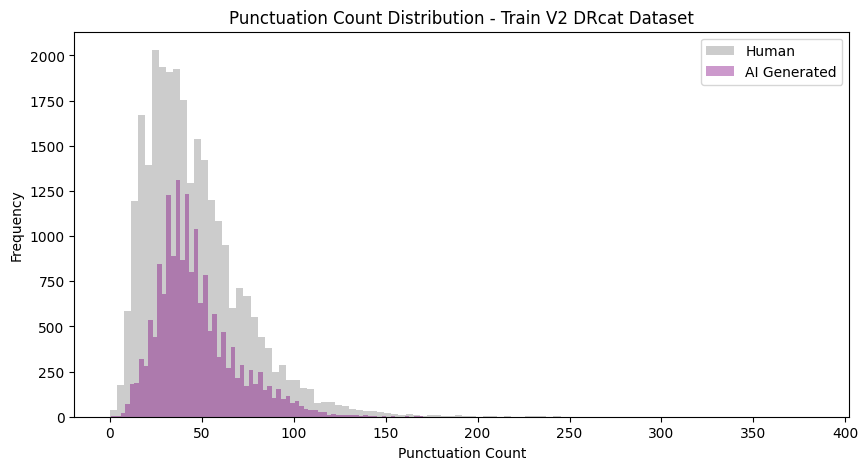

In [10]:


def eda_function(df, label_column="label", text_column="text", dataset_name="Dataset"):
    # Print class distribution
    class_dist = df[label_column].value_counts(normalize=True) * 100
    print(f"\nClass Distribution in {dataset_name}:")
    print(class_dist.rename_axis(label_column).reset_index(name="Percentage"))

    # Calculate word and punctuation counts
    df['word_count'] = df[text_column].apply(lambda text: len(text.split()) if pd.notnull(text) else 0)
    df['punctuation_count'] = df[text_column].apply(lambda text: len(re.findall(r'[^\w\s]', text)) if pd.notnull(text) else 0)

    # Separate data by class (Human vs. AI)
    human_data = df[df[label_column] == 0]
    ai_data = df[df[label_column] == 1]

    # Plot word count distribution
    plt.figure(figsize=(10, 5))
    plt.hist(human_data['word_count'], bins=100, alpha=0.4, label="Human", color='gray')
    plt.hist(ai_data['word_count'], bins=100, alpha=0.4, label="AI Generated", color='purple')
    plt.title(f"Word Count Distribution - {dataset_name}")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Plot punctuation count distribution
    plt.figure(figsize=(10, 5))
    plt.hist(human_data['punctuation_count'], bins=100, alpha=0.4, label="Human", color='gray')
    plt.hist(ai_data['punctuation_count'], bins=100, alpha=0.4, label="AI Generated", color='purple')
    plt.title(f"Punctuation Count Distribution - {dataset_name}")
    plt.xlabel("Punctuation Count")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Drop temporary columns after plotting to avoid modifying original data
    df.drop(columns=['word_count', 'punctuation_count'], inplace=True)

# Usage example:
# Call this function on each dataset
eda_function(df_ai_human, label_column="generated", text_column="text", dataset_name="AI Human Dataset")
eda_function(df_augdata_llm_detectai_train, label_column="label", text_column="text", dataset_name="AugData LLM DetectAI Train Dataset")
eda_function(df_huggingface, label_column="generated", text_column="text", dataset_name="Huggingface Dataset")
eda_function(df_encoded_human_vs_llm, label_column="label", text_column="text", dataset_name="Human vs LLM Corpus")
eda_function(df_train_v2_drcat, label_column="label", text_column="text", dataset_name="Train V2 DRcat Dataset")